# Продвинутое машинное обучение: ДЗ 2

Студент: Бакулев Владимир Леонидович

Группа: MADE-DS-22

Почта: vlbakulev@gmail.com

In [1]:
import json, pickle

from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Задание 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о
составах команд и повопросных результатах (поле "mask" в results.pkl). Для унификации
предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года;
- в тестовый — турниры с dateStart из 2020 года.

### Решение

##### Загрузка исходных данных

In [2]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
results = pickle.load(open('chgk/results.pkl', 'rb'))
players = pickle.load(open('chgk/players.pkl', 'rb'))

##### Предобработка tournaments:

In [3]:
init_tour_df = pd.DataFrame(tournaments).transpose()
init_tour_df.head(2)

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None


In [4]:
tour_df = init_tour_df.copy()

tour_df = tour_df.dropna(subset=['questionQty'])

tour_df['year'] = tour_df['dateStart'].apply(lambda x: int(x[:4]))
tour_df['count_question'] = tour_df['questionQty'].apply(lambda x: sum(x.values()))

tour_df = tour_df[['id', 'name', 'year', 'count_question']]
tour_df = tour_df.rename(columns={'id': 'id_tour', 'name': 'name_tour'})
tour_df.head(2)

,id_tour,name_tour,year,count_question
22,22,Чемпионат России,2004,90
76,76,Чемпионат России,2005,90


##### Предобработка results:

In [5]:
res_dict = defaultdict(list)

for _id_tour, _list_team in results.items():
    for _team in _list_team:
        if not _team.get('mask'):
            continue
        current_mask = list(_team['mask'])
        current_mask = [0 if x in ['0', 'X', '?'] else int(x) for x in current_mask]
        count_all_answer = len(current_mask)
        count_true_answer = sum(current_mask)
        for _player in _team['teamMembers']:
            res_dict['id_tour'].append(_id_tour)
            res_dict['id_team'].append(_team['team']['id'])
            res_dict['id_player'].append(_player['player']['id'])
            res_dict['mask'].append(current_mask)
            res_dict['count_all_answer'].append(count_all_answer)
            res_dict['count_true_answer'].append(count_true_answer)
            
res_df = pd.DataFrame(res_dict)
res_df.head(2)

,id_tour,id_team,id_player,mask,count_all_answer,count_true_answer
0,22,1,1560,"[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...",90,67
1,22,1,2935,"[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...",90,67


##### Предобработка players:

In [6]:
init_players_df = pd.DataFrame(players).transpose()
init_players_df = init_players_df.fillna('')

In [7]:
dict_player = defaultdict(list)

for idx in init_players_df.index.tolist():
    full_name = ' '.join([
        init_players_df.loc[idx, 'surname'],
        init_players_df.loc[idx, 'name'], 
        init_players_df.loc[idx, 'patronymic'],
    ])
    dict_player['id_player'].append(init_players_df.loc[idx, 'id'])
    dict_player['name_player'].append(full_name)
    
player_df = pd.DataFrame(dict_player)
player_df.to_csv('player_df.csv', index=False)

##### Формирование train и test

In [8]:
train_tour_df = tour_df[tour_df['year'] == 2019]
test_tour_df = tour_df[tour_df['year'] == 2020]

print('Общее количество турниров в 2019 году:', train_tour_df.shape[0])
print('Общее количество турниров в 2020 году:', test_tour_df.shape[0])

Общее количество турниров в 2019 году: 687
Общее количество турниров в 2020 году: 418


In [9]:
init_train_df = pd.merge(train_tour_df, res_df, how='inner', on='id_tour')
init_train_df = init_train_df[init_train_df['count_question'] == init_train_df['count_all_answer']]

print('Количество турниров в тренировочном датасете:', len(init_train_df['id_tour'].unique()))
print('Количество уникальных команд в тренировочном датасете:', len(init_train_df['id_team'].unique()))
print('Количество уникальных игроков в тренировочном датасете:', len(init_train_df['id_player'].unique()))
print('Количество вопросов в тренировочном датасете:', 
      int(init_train_df.groupby(['id_tour'])['id_tour', 'count_question'].agg('mean').sum()))

init_train_df.head(2)

Количество турниров в тренировочном датасете: 675
Количество уникальных команд в тренировочном датасете: 11420
Количество уникальных игроков в тренировочном датасете: 57429
Количество вопросов в тренировочном датасете: 33381


,id_tour,name_tour,year,count_question,id_team,id_player,mask,count_all_answer,count_true_answer
0,4772,Синхрон северных стран. Зимний выпуск,2019,36,45556,6212,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",36,28
1,4772,Синхрон северных стран. Зимний выпуск,2019,36,45556,18332,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",36,28


In [10]:
init_test_df = pd.merge(test_tour_df, res_df, how='inner', on='id_tour')
init_test_df = init_test_df[init_test_df['count_question'] == init_test_df['count_all_answer']]

print('Количество турниров в тестовом датасете:', len(init_test_df['id_tour'].unique()))
print('Количество уникальных команд в тестовом датасете:', len(init_test_df['id_team'].unique()))
print('Количество уникальных игроков в тестовом датасете:', len(init_test_df['id_player'].unique()))
print('Количество вопросов в тестовом датасете:', 
      int(init_test_df.groupby(['id_tour'])['id_tour', 'count_question'].agg('mean').sum()))

init_test_df.head(2)

Количество турниров в тестовом датасете: 172
Количество уникальных команд в тестовом датасете: 5857
Количество уникальных игроков в тестовом датасете: 28996
Количество вопросов в тестовом датасете: 7803


,id_tour,name_tour,year,count_question,id_team,id_player,mask,count_all_answer,count_true_answer
0,4957,Синхрон Биркиркары,2020,39,49804,30152,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...",39,26
1,4957,Синхрон Биркиркары,2020,39,49804,30270,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...",39,26


In [11]:
init_test_df[['id_tour', 'id_team', 'id_player']].to_csv('test_df.csv', index=False)

##### Анализ train

In [12]:
count_tour_per_player = init_train_df.groupby('id_player')[
    'id_player', 'count_all_answer', 'count_true_answer'].agg(['count', 'sum'])
tour_per_player_df = pd.DataFrame.from_dict({
    'id_player' : count_tour_per_player.index.tolist(),
    'count_tour_per_player': count_tour_per_player['id_player']['count'].tolist(),
    'count_all_answer_per_player': count_tour_per_player['count_all_answer']['sum'].tolist(),
    'count_true_answer_per_player': count_tour_per_player['count_true_answer']['sum'].tolist(),
})
tour_per_player_df['percent_true_answer'] = tour_per_player_df['count_true_answer_per_player'] / \
tour_per_player_df['count_all_answer_per_player'] *100

tour_per_player_df.head(2)

,id_player,count_tour_per_player,count_all_answer_per_player,count_true_answer_per_player,percent_true_answer
0,15,13,481,167,34.719335
1,16,3,198,104,52.525253


In [13]:
def print_hist(data, data_name): 
    
    data_info = ''
    data_info = ' '.join([data_info, '(медиана:', str(round(data.median(), 3)), ','])
    data_info = ' '.join([data_info, 'максимум:', str(round(data.max(), 3)), ','])
    data_info = ' '.join([data_info, '25-процентиль:', str(round(np.percentile(data, 25), 3)), ','])
    data_info = ''.join([data_info, ' 75-процентиль: ', str(round(np.percentile(data, 75), 3)), ')'])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, 
                                        figsize=(12, 5))

    sns.boxplot(data, ax=ax_box)
    sns.distplot(data, kde=False, ax=ax_hist)
    ax_box.set(xlabel='')
    
    ax_box.grid()
    ax_hist.grid()
    
    f.suptitle('\n'.join([data_name, data_info]), fontsize=14)
    plt.show()

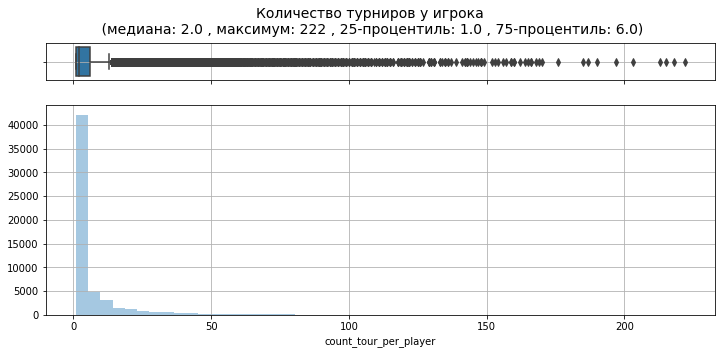

In [14]:
print_hist(tour_per_player_df["count_tour_per_player"], data_name='Количество турниров у игрока')

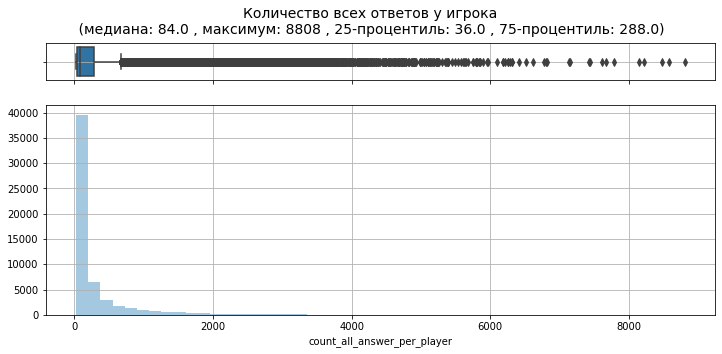

In [15]:
print_hist(tour_per_player_df['count_all_answer_per_player'], data_name='Количество всех ответов у игрока')

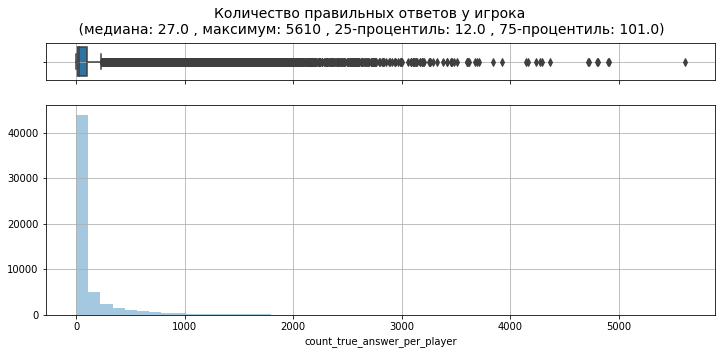

In [16]:
print_hist(tour_per_player_df['count_true_answer_per_player'], data_name='Количество правильных ответов у игрока')

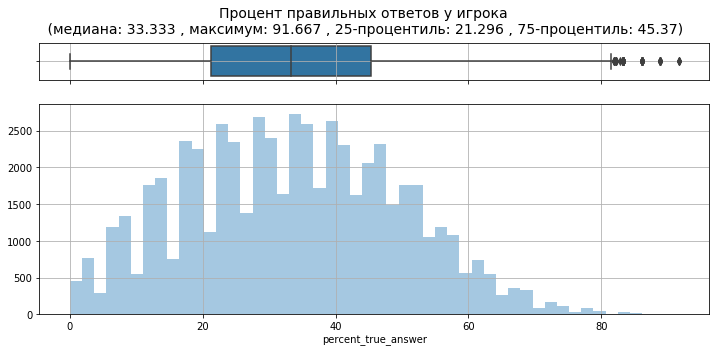

In [17]:
print_hist(tour_per_player_df['percent_true_answer'], data_name='Процент правильных ответов у игрока')

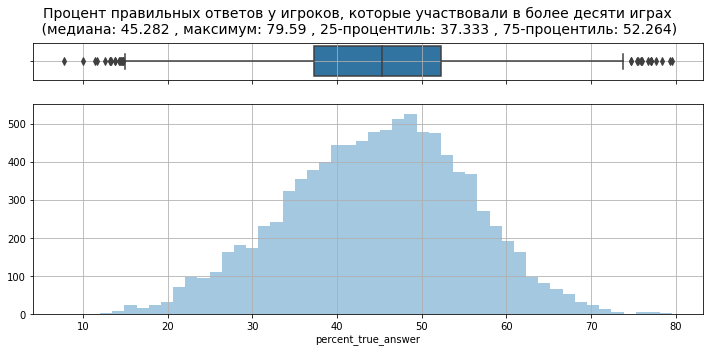

In [18]:
print_hist(
    tour_per_player_df[tour_per_player_df['count_tour_per_player'] > 10. ]['percent_true_answer'], 
    data_name='Процент правильных ответов у игроков, которые участвовали в более десяти играх'
)

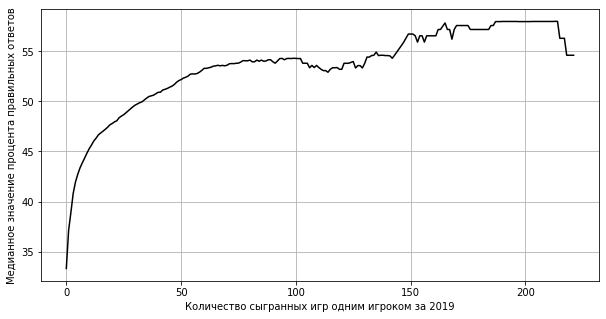

In [19]:
array_count_tour_per_player = list(range(222))
array_percenr_true_answer = []
for i in array_count_tour_per_player:
    array_percenr_true_answer.append(tour_per_player_df[
        tour_per_player_df['count_tour_per_player'] > i]['percent_true_answer'].median())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(array_count_tour_per_player, array_percenr_true_answer, 'k')
ax.set_xlabel('Количество сыгранных игр одним игроком за 2019')
ax.set_ylabel('Медианное значение процента правильных ответов')
ax.grid()

In [20]:
add_train_df = init_train_df.copy()
add_train_df = pd.merge(add_train_df, tour_per_player_df, how='inner', on='id_player')

In [22]:
train_dict = defaultdict(list)

for idx in add_train_df.index.tolist():
    id_tour = add_train_df.loc[idx, 'id_tour']
    for i, m in enumerate(add_train_df.loc[idx, 'mask']):
        id_question = '_'.join([str(id_tour), str(i)])
        train_dict['id_tour'].append(id_tour)
        train_dict['id_team'].append(add_train_df.loc[idx, 'id_team'])
        train_dict['id_player'].append(add_train_df.loc[idx, 'id_player'])
        train_dict['id_question'].append(id_question)
        train_dict['answer'].append(m)

In [23]:
train_df = pd.DataFrame(train_dict)
train_df.head(2)

,id_tour,id_team,id_player,id_question,answer
0,4772,45556,6212,4772_0,1
1,4772,45556,6212,4772_1,1


In [24]:
train_df.to_csv('prepare_train_df.csv', index=False)
train_df.shape

(17838582, 5)

In [25]:
count_question = train_df.groupby('id_question')['id_team', 'answer'].agg(['count', 'sum'])
question_df = pd.DataFrame.from_dict({
    'id_question': count_question.index.tolist(),
    'count_answer': count_question['answer']['count'].tolist(),
    'count_true_answer': count_question['answer']['sum'].tolist(),
})
question_df['persent_true_answer'] = 100. * question_df['count_true_answer'] / question_df['count_answer']

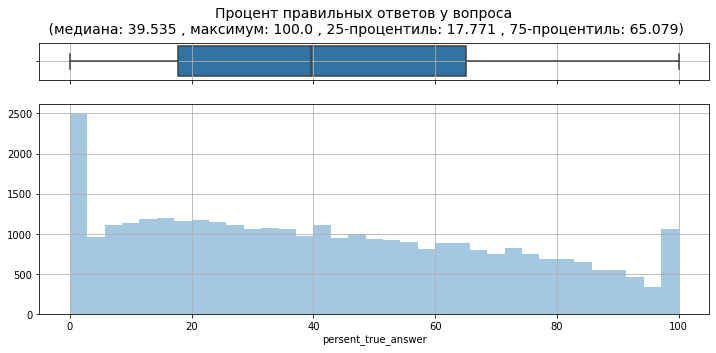

In [26]:
print_hist(question_df['persent_true_answer'], data_name='Процент правильных ответов у вопроса')

Анализ исходных данных показал вполне закономерные результаты:
- в игре больше сложных вопросов, чем легких (под сложностью принимаем процент верных ответов). При этом есть вопросы, на которые ответили все, и те, на которые не ответил никто
- игроки, которые чаще принимают участие в турнирах, имеют больший процент правильных отетов

### Задание 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

In [27]:
train_df = pd.read_csv('prepare_train_df.csv')
player_df = pd.read_csv('player_df.csv')

print('Размер исходного датасета:', train_df.shape[0])

Размер исходного датасета: 17838582


### Решение

Baseline-модель основана на логистической регресии. ID игрока и ID вопроса - это категориальные переменные, поэтому их преобразовываем в логические переменные и записываем данные в разреженную матрице

In [28]:
list_player_in_train = train_df['id_player'].unique().tolist()
dict_player_in_train = {
    _player: i for i, _player in enumerate(list_player_in_train)
}

list_question_in_train = train_df['id_question'].unique().tolist()
dict_question_in_train = {
    _question: i for i, _question in enumerate(list_question_in_train)
}

In [29]:
from scipy import sparse

def transform_to_sparse(input_df, dict_player, dict_question):
    no_player = [dict_player[p] for p in train_df['id_player'].tolist()]
    no_question = [dict_question[q] for q in train_df['id_question'].tolist()]
    
    X_train = sparse.lil_matrix((len(dict_player) + len(dict_question), input_df.shape[0]))
    X_train[no_player, list(range(input_df.shape[0]))] = 1

    X_train[[no_q + len(dict_player) for no_q in no_question], list(range(input_df.shape[0]))] = 1
    return X_train.transpose()

In [30]:
X_train = transform_to_sparse(train_df, dict_player_in_train, dict_question_in_train)
y_train = train_df['answer']

Обучение логистической регресии

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [32]:
%%time
clf = LogisticRegression(random_state=42, C=4.2).fit(X_train, y_train)
print('ROC-AUC: %.4f' % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

ROC-AUC: 0.8507
CPU times: user 2min 48s, sys: 31.6 s, total: 3min 20s
Wall time: 2min 47s


Рейтинг игрока - это значение компоненты вектора модели, соответствующего заданному игроку. Чем больше этот коэффициент, тем больше сумма под сигмойдой логистической регресии и, соответственно, тем больше вклад игрока в вероятность правильно ответить команде.

In [33]:
def model_rating_players(input_clf, dict_player):
    coef_player = input_clf.coef_[0][:len(dict_player)]
    rating_dict = defaultdict(list)
    
    for i, _player in enumerate(dict_player.keys()):
        rating_dict['id_player'].append(_player)
        rating_dict['rating'].append(coef_player[i])
        
    rating_df = pd.DataFrame(rating_dict)
    rating_df = pd.merge(player_df, rating_df, how='inner', on='id_player')
    return rating_df

In [34]:
baseline_rating_players_df = model_rating_players(clf, dict_player_in_train)
baseline_rating_players_df.sort_values(by='rating', ascending=False).head(25)

,id_player,name_player,rating
3862,27403,Руссо Максим Михайлович,3.822337
604,4270,Брутер Александра Владимировна,3.679971
4239,30152,Сорожкин Артём Сергеевич,3.601156
4051,28751,Семушин Иван Николаевич,3.475942
3934,27822,Савченков Михаил Владимирович,3.388627
4793,34328,Царёв Михаил Сергеевич,3.349827
4259,30270,Спешков Сергей Леонидович,3.347212
5181,37047,Юнгер Мария Алексеевна,3.327710
544,3843,Бомешко Светлана Борисовна,3.285401
55487,216863,Гаврилов Глеб Юрьевич,3.256463


Полученный рейтинг примерно соответствует текущему рейтингу с сайта ЧГК.

### Задача 3
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy ) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

### Решение

В тестовом наборе мы не знаем сложность вопросов, но как и в ретроспективном исследовании (как на лекции) это не помешает оценить вклад известных параметров (а это составы команд) в вероятность ответить правильно на вопросы.
Оценим потенциал команды как сумму рейтингов игроков. У кого эта сумма больше, тот и выигрывает турнир.

In [35]:
test_df = pd.read_csv('test_df.csv')
test_df = test_df[test_df['id_player'].isin(dict_player_in_train.keys())]
test_df.head(5)

,id_tour,id_team,id_player
0,4957,49804,30152
1,4957,49804,30270
2,4957,49804,27822
3,4957,49804,28751
4,4957,49804,27403


In [36]:
test_result_df = test_df.copy()#['id_tour', 'id_team']
test_result_df.drop_duplicates(subset=['id_tour', 'id_team'], inplace=True)
test_result_df = test_result_df[['id_tour', 'id_team']]

list_tour = test_df['id_tour'].unique().tolist()
rating_team = []

for id_tour in list_tour:
    current_tour_df = test_result_df[test_result_df['id_tour'] == id_tour]
    list_team = current_tour_df['id_team'].unique().tolist()
    for i, _team in enumerate(list_team):
        rating_team.append(i + 1)

test_result_df['place_in_tour'] = rating_team
test_result_df.head(10)

,id_tour,id_team,place_in_tour
0,4957,49804,1
6,4957,4109,2
12,4957,3875,3
18,4957,77418,4
24,4957,2,5
30,4957,45367,6
35,4957,4622,7
41,4957,4174,8
46,4957,75600,9
53,4957,59580,10


In [37]:
def predict_place_in_tour(input_clf, input_df, dict_player, input_result_df):
    dict_model_place = defaultdict(list)
    
    rating_players_df = model_rating_players(input_clf, dict_player)
    list_tour = input_df['id_tour'].unique().tolist()
    for id_tour in list_tour:
        current_tour_df = input_df[input_df['id_tour'] == id_tour]
        list_team = current_tour_df['id_team'].unique().tolist()
        
        array_sum_rating = []
        for i, _team in enumerate(list_team):
            current_team_df = current_tour_df[current_tour_df['id_team'] == _team]
            sum_rating = 0
            for _player in current_team_df['id_player'].tolist():
                if _player in dict_player.keys():
                    sum_rating += rating_players_df[rating_players_df['id_player'] == _player]['rating'].values[0]
            array_sum_rating.append((_team, sum_rating))
            
        array_sum_rating = sorted(array_sum_rating, key=lambda l: l[1], reverse=True)
        for j, _rating in enumerate(array_sum_rating):
            dict_model_place['id_tour'].append(id_tour)
            dict_model_place['id_team'].append(_rating[0])
            dict_model_place['model_place_in_tour'].append(j + 1)
            
    return pd.merge(input_result_df, pd.DataFrame(dict_model_place), how='inner', on=['id_tour', 'id_team'])

In [38]:
model_result_df = predict_place_in_tour(clf, test_df, dict_player_in_train, test_result_df)
model_result_df.head(10)

,id_tour,id_team,place_in_tour,model_place_in_tour
0,4957,49804,1,1
1,4957,4109,2,8
2,4957,3875,3,10
3,4957,77418,4,3
4,4957,2,5,4
5,4957,45367,6,9
6,4957,4622,7,12
7,4957,4174,8,29
8,4957,75600,9,6
9,4957,59580,10,15


In [39]:
from scipy.stats import spearmanr, kendalltau

def calculate_corr(res_df, return_data=False):
    sp_array, kd_array = [], []
    
    list_tour = res_df['id_tour'].unique().tolist()
    for id_tour in list_tour:
        current_tour_df = res_df[res_df['id_tour'] == id_tour]
        if len(current_tour_df['model_place_in_tour'].values) > 1:
            s = spearmanr(current_tour_df['place_in_tour'].values, 
                          current_tour_df['model_place_in_tour'].values)[0]
            sp_array.append(s)
            k = kendalltau(current_tour_df['place_in_tour'].values, 
                           current_tour_df['model_place_in_tour'].values)[0]
            kd_array.append(k)
    
    print('Корреляция Спирмена: MEAN___%.3f, MEDIAN___%.3f' % (np.mean(sp_array), np.median(sp_array)))
    print('Корреляция Кендала: MEAN___%.3f, MEDIAN___%.3f' % (np.mean(kd_array),np.median(kd_array)))
    if return_data:
        return sp_array, kd_array

In [40]:
calculate_corr(model_result_df)

Корреляция Спирмена: MEAN___0.769, MEDIAN___0.800
Корреляция Кендала: MEAN___0.599, MEDIAN___0.614


Значения корелляций указывают на корректность предположений и верную реализацию baseline-модели

### Задание 4
Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

### Решение

In [44]:
import torch
import torch.nn as nn
from torch.nn import functional as F

### Задание 5
А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)?
Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе
вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

### Решение

По аналогии с рейтингом игроков будем считать сложностью вопроса его коэффициент в логистической регресии. При этом чем он меньше (тем меньше сумма под сигмойдой и меньше вероятность правильного ответа), тем вопрос сложнее. Сложность турнира оценим как медианное значение сложностей вопросов.

In [59]:
def model_rating_question(input_clf, dict_player, dict_question):
    coef_question = input_clf.coef_[0][len(dict_player): (len(dict_player) + len(dict_question))]
    rating_dict = defaultdict(list)
    
    for i, _question in enumerate(dict_question.keys()):
        rating_dict['id_question'].append(_question)
        rating_dict['rating'].append(coef_question[i])
        
    rating_df = pd.DataFrame(rating_dict)
    return pd.merge(train_df, rating_df, how='inner', on='id_question')

In [65]:
rating_question_df = model_rating_question(clf, dict_player_in_train, dict_question_in_train)
rating_tour_df = rating_question_df.groupby('id_tour')['rating'].agg(np.median).reset_index()
rating_tour_df = pd.merge(
    tour_df, rating_tour_df, how='inner', on='id_tour').sort_values('rating')[['name_tour', 'rating']]

In [66]:
rating_tour_df.head(20)

,name_tour,rating
663,Чемпионат Санкт-Петербурга. Первая лига,-3.405075
541,Угрюмый Ёрш,-2.479485
369,Синхрон высшей лиги Москвы,-2.453949
639,Воображаемый музей,-2.021068
43,Первенство правого полушария,-1.988930
594,Тихий Донец: омут первый,-1.919273
284,Записки охотника,-1.911678
26,Ускользающая сова,-1.765630
225,Чемпионат Минска. Лига А. Тур четвёртый,-1.742771
67,Мемориал Дмитрия Коноваленко,-1.695851


In [67]:
rating_tour_df.tail(20)

,name_tour,rating
386,(а)Синхрон-lite. Лига старта. Эпизод X,1.481338
524,"Ничто, нигде, никогда",1.487170
9,(а)Синхрон-lite. Лига старта. Эпизод IV,1.537593
491,Летний салат,1.559555
529,Осенняя кинолига,1.565680
221,KFC,1.572107
200,Школьнае люстэрка,1.586981
38,Лига Сибири. VI тур.,1.604922
399,Синхрон-lite. Выпуск XXX,1.610264
384,(а)Синхрон-lite. Лига старта. Эпизод IX,1.613236


Полученные результаты соответствуют интуиции